In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy
from ripser import ripser
from persim import plot_diagrams

In [3]:
C22F002 = pd.read_csv('C22F002.csv')

In [4]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

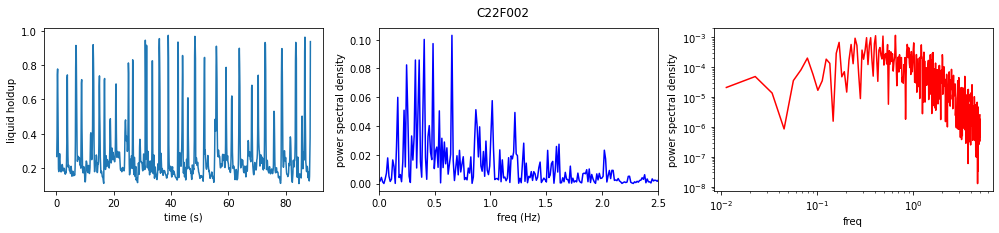

In [5]:
fig_C22F002, data = plt.subplots(1, 3, figsize=(17, 3))

fig_C22F002.suptitle('C22F002')
data[0].set_xlabel('time (s)')
data[0].set_ylabel('liquid holdup')
data[1].set_xlabel('freq (Hz)')
data[1].set_ylabel('power spectral density')
data[1].set_xlim([0,2.5])
data[2].set_xlabel('freq')
data[2].set_ylabel('power spectral density')

freqs, ps, psd = spectrum1(C22F002[C22F002.columns[1]], dt=0.1)

data[0].plot(C22F002[C22F002.columns[0]],C22F002[C22F002.columns[1]])
#data[1].loglog(freqs,psd,'r',freqs,ps,'b')
data[1].plot(freqs,psd,'b')
data[2].loglog(freqs,ps,'r')



In [6]:
type(C22F002)

pandas.core.frame.DataFrame

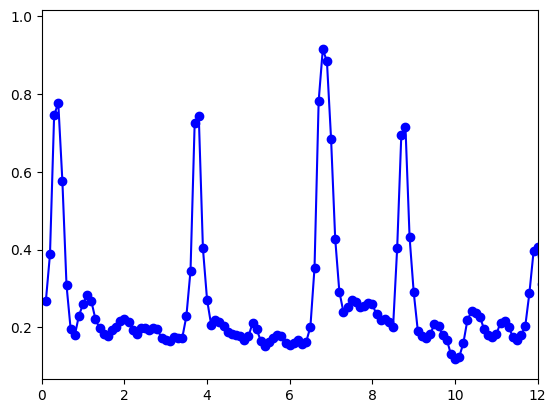

In [31]:
plt.xlim([0,12])
plt.plot(C22F002[C22F002.columns[0]],C22F002[C22F002.columns[1]], 'bo-')

In [37]:
slug_signal = C22F002.iloc[:, 1]

In [38]:
def TDAanalyze(signal, stride):

    max_time_delay = int(len(signal)/2) 
    max_embedding_dimension = int(len(signal)/20)
    print('length of signal to analyze', len(signal))
    print('max time delay', max_time_delay)
    print('max dim embedding', max_embedding_dimension)
    print('stride', stride)

    optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
        signal, max_time_delay, max_embedding_dimension, stride=stride
        )

    print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
    print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")
    
    embedding_dimension = optimal_embedding_dimension
    embedding_time_delay = optimal_time_delay
    stride = stride

    embedder = SingleTakensEmbedding(
        parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
        )

    y_signal_embedded = embedder.fit_transform(signal)

    pca = PCA(n_components=3)
    y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

    plot_point_cloud(y_signal_embedded_pca)
    
    homology_dimensions = (0, 1, 2)
    VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

    y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)
 
    PH_signal = VRP.fit_transform(y_signal_embedded_reshaped)
    VRP.plot(PH_signal)
    PE_signal = PersistenceEntropy()
    features = PE_signal.fit_transform(PH_signal)

    
    return features

In [39]:
print('length of signal to analyze', len(slug_signal))

max_time_delay = 10
max_embedding_dimension = 80
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    slug_signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

length of signal to analyze 886
Optimal embedding time delay based on mutual information: 9
Optimal embedding dimension based on false nearest neighbors: 8


In [40]:
embedding_dimension = 8
embedding_time_delay = 9
stride = 2

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [41]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 416, 7)
y_slug_embedded.shape (416, 7)


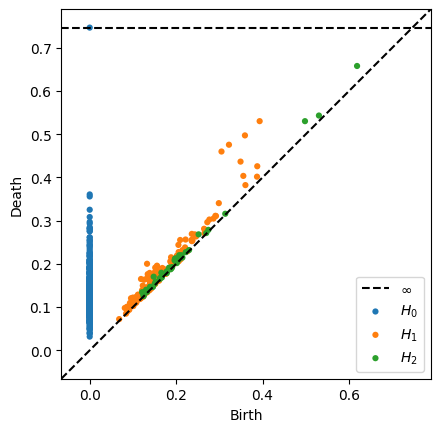

In [42]:
dgms = ripser(y_slug_embedded, maxdim=2)['dgms']
plot_diagrams(dgms, show=True)

In [43]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[8.58724305, 6.61280539, 4.86099399]])

In [61]:
embedding_dimension = 20
embedding_time_delay = 5
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [62]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 856, 7)
y_slug_embedded.shape (856, 7)


In [63]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[9.56614713, 8.00354027, 5.95416828]])

In [49]:
TDAanalyze(slug_signal, 1)

length of signal to analyze 886
max time delay 443
max dim embedding 44
stride 1
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 8


array([[9.5207678 , 8.02061376, 6.37559213]])

In [50]:
TDAanalyze(slug_signal, 2)

length of signal to analyze 886
max time delay 443
max dim embedding 44
stride 2
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 10


array([[8.48456645, 6.72659428, 4.76899454]])

Albeit there is very low persistence in this timeseries, the homology class H_2 has extremely low entropy. This is sign of order in the high dimensional structure.

In [51]:
C22F002_downsampled_2 = C22F002.iloc[::2, :]
C22F002_downsampled_2

,time(s),liquid holdup
0,0.1,0.267684
2,0.3,0.744619
4,0.5,0.575393
6,0.7,0.195540
8,0.9,0.230115
...,...,...
876,87.7,0.173447
878,87.9,0.154947
880,88.1,0.163688
882,88.3,0.152851


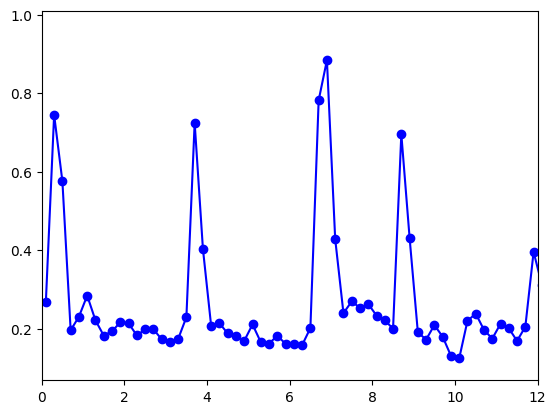

In [52]:
plt.xlim([0,12])
plt.plot(C22F002_downsampled_2[C22F002_downsampled_2.columns[0]],C22F002_downsampled_2[C22F002_downsampled_2.columns[1]], 'bo-')

In [53]:
slug_signal_down = C22F002_downsampled_2.iloc[:, 1]
slug_signal_down.size
TDAanalyze(slug_signal_down, 2)

length of signal to analyze 443
max time delay 221
max dim embedding 22
stride 2
Optimal embedding time delay based on mutual information: 8
Optimal embedding dimension based on false nearest neighbors: 9


array([[7.37728829, 6.05979254, 4.75273863]])

length of signal to analyze 296
max time delay 148
max dim embedding 14
stride 1
Optimal embedding time delay based on mutual information: 5
Optimal embedding dimension based on false nearest neighbors: 8


array([[7.84817101, 6.05865544, 3.52692519]])

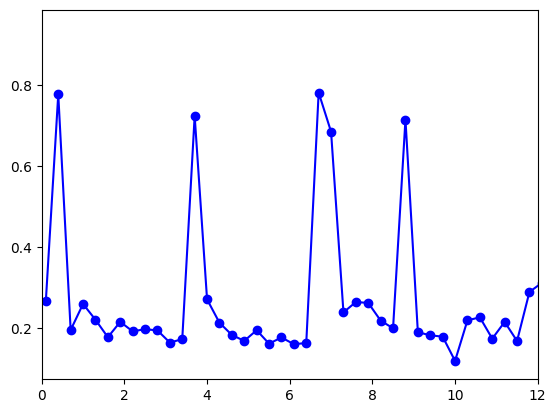

In [59]:
C22F002_downsampled_3 = C22F002.iloc[::3, :]
slug_signal_down = C22F002_downsampled_3.iloc[:, 1]
plt.xlim([0,12])
plt.plot(C22F002_downsampled_3[C22F002_downsampled_3.columns[0]],C22F002_downsampled_3[C22F002_downsampled_3.columns[1]], 'bo-')
TDAanalyze(slug_signal_down, 1)

In [60]:
embedding_dimension = 5
embedding_time_delay = 8
stride = 2

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal_down)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [56]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 143, 3)
y_slug_embedded.shape (143, 3)


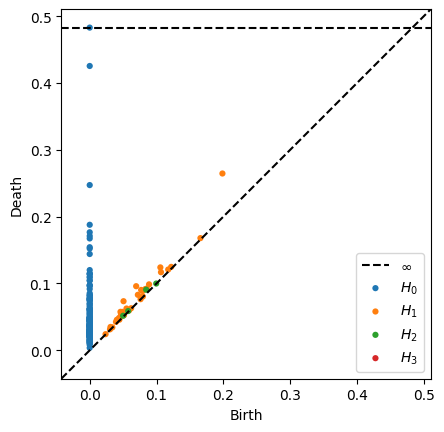

In [57]:
dgms = ripser(y_slug_embedded, maxdim=3)['dgms']
plot_diagrams(dgms, show=True)